In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Flatten, Reshape, UpSampling2D
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from joblib import dump, load
import visualkeras


## Load Data

In [2]:
img_height = 224
img_width = 224

def read_data(data_dir, size, color, img_size):
    datagen = ImageDataGenerator()
    itr = datagen.flow_from_directory(data_dir, batch_size=size, color_mode=color, class_mode='categorical',
                                        target_size=img_size, shuffle=True, seed=0)
    return itr


train_dir = 'cat_rabbit/train-cat-rabbit'
train_gen = read_data(train_dir, 1600, 'grayscale', (img_height, img_width))
X_train, y_train = train_gen.next()

test_dir = 'cat_rabbit/val-cat-rabbit'
test_gen = read_data(test_dir, 414, 'grayscale', (img_height, img_width))
X_test, y_test = test_gen.next()

Found 1600 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [3]:
X_train_reshape = X_train.reshape(1600, img_height * img_width)
X_test_reshape = X_test.reshape(414, img_height * img_width)

y_train_reshape = np.argmax(y_train, axis = 1)
y_test_reshape = np.argmax(y_test, axis = 1)

rep_X_train = np.repeat(X_train, 3, -1)
rep_X_test = np.repeat(X_test, 3, -1)

label_dict = {0: 'cat', 1: 'rabbit'}

## Pure Logisitic Regression

In [20]:
logreg =  LogisticRegression(random_state = 0, max_iter = 200, solver = 'saga')
logreg.fit(X_train_reshape, y_train_reshape)

c:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(max_iter=200, random_state=0, solver='saga')

In [23]:
# dump(logreg, 'logreg.joblib')
logreg = load('models/logreg.joblib')

In [24]:
logreg_pred = logreg.predict(X_test_reshape)
print(classification_report(y_test_reshape, logreg_pred, target_names = ['cat', 'rabbit']))

              precision    recall  f1-score   support

         cat       0.58      0.68      0.62       207
      rabbit       0.61      0.51      0.55       207

    accuracy                           0.59       414
   macro avg       0.59      0.59      0.59       414
weighted avg       0.59      0.59      0.59       414



In [25]:
confusion_matrix(y_test_reshape, logreg_pred)

array([[140,  67],
       [102, 105]], dtype=int64)

## VGG19

In [76]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [77]:
vgg19.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [89]:
optimizer = Adam()
for layer in vgg19.layers:
    layer.trainable = False
output_dim = vgg19.output
pooling = GlobalAveragePooling2D()(output_dim)
dense1 = Dense(256, activation='relu')(pooling)
dense2 = Dense(128, activation='relu')(dense1)
dropout = Dropout(0.1)(dense2)
output = Dense(2, activation='softmax')(dropout)

vgg19_custom = Model(inputs = vgg19.input, outputs = output)

vgg19_custom.compile(optimizer=optimizer, 
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [90]:
vgg19_custom.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [91]:
model_name = "vgg_19_cr_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)



In [92]:
try:
    history = vgg19_custom.fit(x = rep_X_train,
                               y = y_train,
                           epochs=10,
                           validation_data=(rep_X_test, y_test),
                           callbacks=[checkpoint, earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/10
50/50 [==============================] - 133s 3s/step - loss: 0.4085 - accuracy: 0.8970 - val_loss: 0.1812 - val_accuracy: 0.9493

Epoch 00001: val_loss improved from inf to 0.18121, saving model to vgg_19_cr_model.h5
Epoch 2/10
50/50 [==============================] - 129s 3s/step - loss: 0.0481 - accuracy: 0.9772 - val_loss: 0.0529 - val_accuracy: 0.9831

Epoch 00002: val_loss improved from 0.18121 to 0.05294, saving model to vgg_19_cr_model.h5
Epoch 3/10
50/50 [==============================] - 128s 3s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9686

Epoch 00003: val_loss did not improve from 0.05294
Epoch 4/10
50/50 [==============================] - 127s 3s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9734

Epoch 00004: val_loss did not improve from 0.05294
Epoch 5/10
50/50 [==============================] - 127s 3s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0552 - val_accuracy: 0.9734

Epoch 0000

In [6]:
vgg19_custom = load_model('models/vgg_19_cr_model.h5')

In [240]:
vgg_pred = vgg19_custom.predict(rep_X_test)
vgg19_pred = np.argmax(vgg_pred, axis = 1)

In [241]:
print(classification_report(y_test_reshape, vgg19_pred, target_names = ['cat', 'rabbit']))

              precision    recall  f1-score   support

         cat       0.99      0.98      0.98       207
      rabbit       0.98      0.99      0.98       207

    accuracy                           0.98       414
   macro avg       0.98      0.98      0.98       414
weighted avg       0.98      0.98      0.98       414



In [242]:
confusion_matrix(y_test_reshape, vgg19_pred)

array([[202,   5],
       [  2, 205]], dtype=int64)

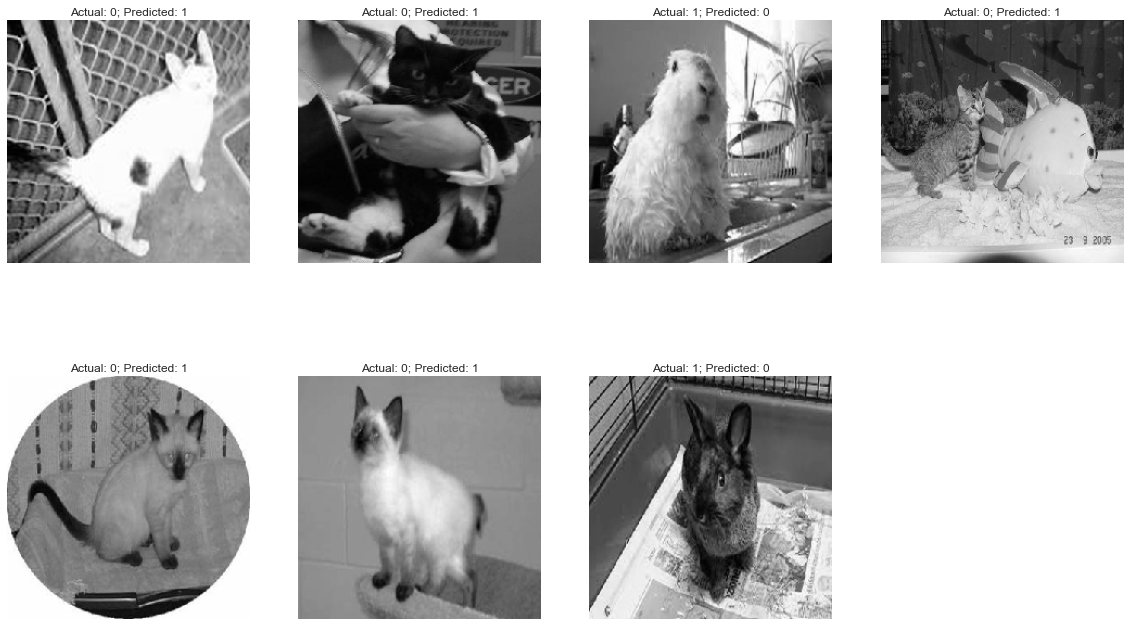

In [245]:
plt.figure(figsize = (20 , 12))

j = 1
for i in np.where(y_test_reshape != vgg19_pred)[0]:

    plt.subplot(2,4,j)
    plt.imshow(X_test[i].reshape(224,224), cmap = 'gray')
    plt.title(f'Actual: {y_test_reshape[i]}; Predicted: {vgg19_pred[i]}')
    plt.axis("off")
    j += 1

## PCA

In [4]:
pca = PCA(n_components = 128)
pca_X_train = pca.fit_transform(X_train_reshape)
pca_X_test = pca.transform(X_test_reshape)

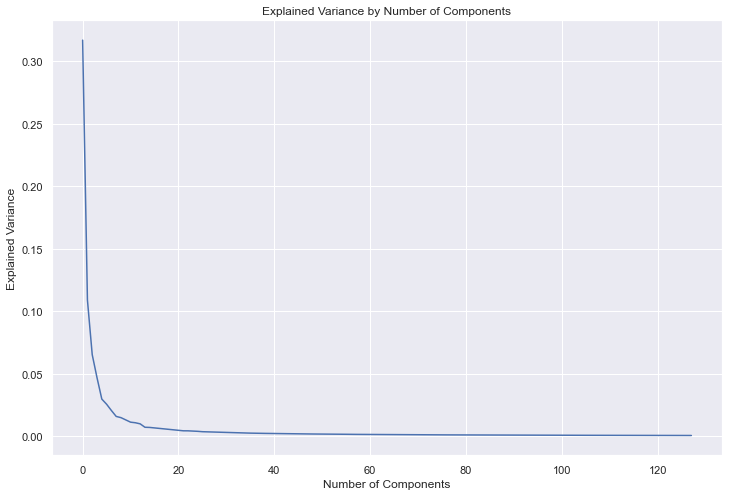

In [222]:
sns.set(rc={'figure.figsize':(12,8)})
plt.figure()
sns.lineplot(pca.explained_variance_ratio_)
# plt.xlim(-1,50)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.savefig('images/lineplot.png')

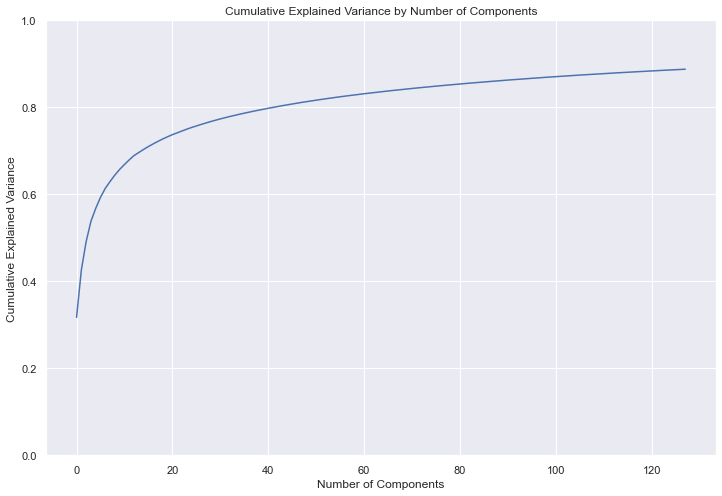

In [223]:
sns.set(rc={'figure.figsize':(12,8)})
plt.figure()
sns.lineplot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim(0,1)
plt.title('Cumulative Explained Variance by Number of Components')
plt.savefig('images/cumplot.png')

In [5]:
pca_logreg = LogisticRegression(random_state = 0, max_iter = 200, solver = 'saga')
pca_logreg.fit(pca_X_train, y_train_reshape)

LogisticRegression(max_iter=200, random_state=0, solver='saga')

In [225]:
pca_logreg_pred = pca_logreg.predict(pca_X_test)
print(classification_report(y_test_reshape, pca_logreg_pred, target_names = ['cat', 'rabbit']))

              precision    recall  f1-score   support

         cat       0.64      0.69      0.66       207
      rabbit       0.66      0.61      0.64       207

    accuracy                           0.65       414
   macro avg       0.65      0.65      0.65       414
weighted avg       0.65      0.65      0.65       414



In [226]:
confusion_matrix(y_test_reshape, pca_logreg_pred)

array([[142,  65],
       [ 80, 127]], dtype=int64)

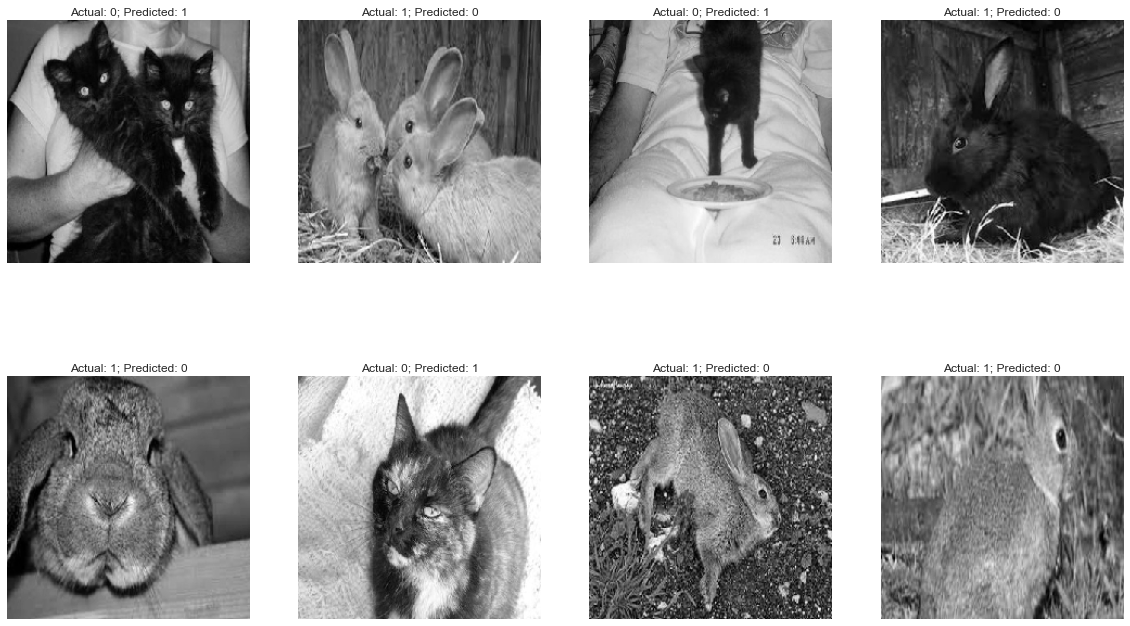

In [266]:
np.random.seed(1)
wrongs = np.where(y_test_reshape != pca_logreg_pred)[0]
np.random.shuffle(wrongs)
plt.figure(figsize = (20 , 12))

j = 1
for i in wrongs[:8]:

    plt.subplot(2,4,j)
    plt.imshow(X_test[i].reshape(224,224), cmap = 'gray')
    plt.title(f'Actual: {y_test_reshape[i]}; Predicted: {pca_logreg_pred[i]}')
    plt.axis("off")
    j += 1

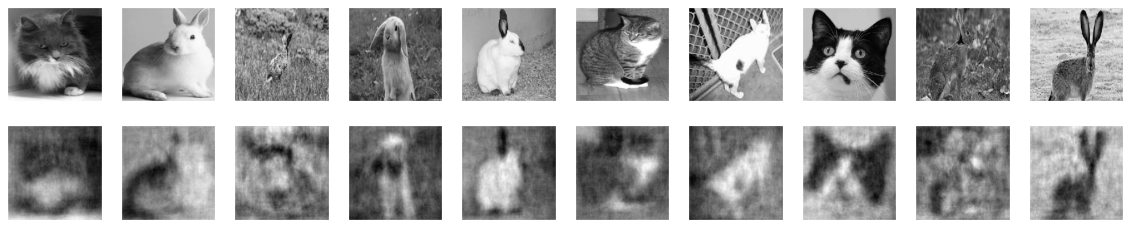

In [228]:
pca_inverse_imgs = pca.inverse_transform(pca_X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(pca_inverse_imgs[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## VGG Encoding

In [7]:
vgg_encoding_model = Model(inputs=vgg19_custom.input, outputs=vgg19_custom.get_layer('dropout_5').output)
encoding_X_train = vgg_encoding_model.predict(rep_X_train)
encoding_X_test = vgg_encoding_model.predict(rep_X_test)

In [8]:
encoder_logreg = LogisticRegression(random_state = 0, max_iter = 200, solver = 'saga')
encoder_logreg.fit(encoding_X_train, y_train_reshape)

c:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(max_iter=200, random_state=0, solver='saga')

In [9]:
encoder_pred = encoder_logreg.predict(encoding_X_test)
print(classification_report(y_test_reshape, encoder_pred, target_names = ['cat', 'rabbit']))

              precision    recall  f1-score   support

         cat       0.98      0.98      0.98       207
      rabbit       0.98      0.98      0.98       207

    accuracy                           0.98       414
   macro avg       0.98      0.98      0.98       414
weighted avg       0.98      0.98      0.98       414



In [10]:
confusion_matrix(y_test_reshape, encoder_pred)

array([[203,   4],
       [  4, 203]], dtype=int64)

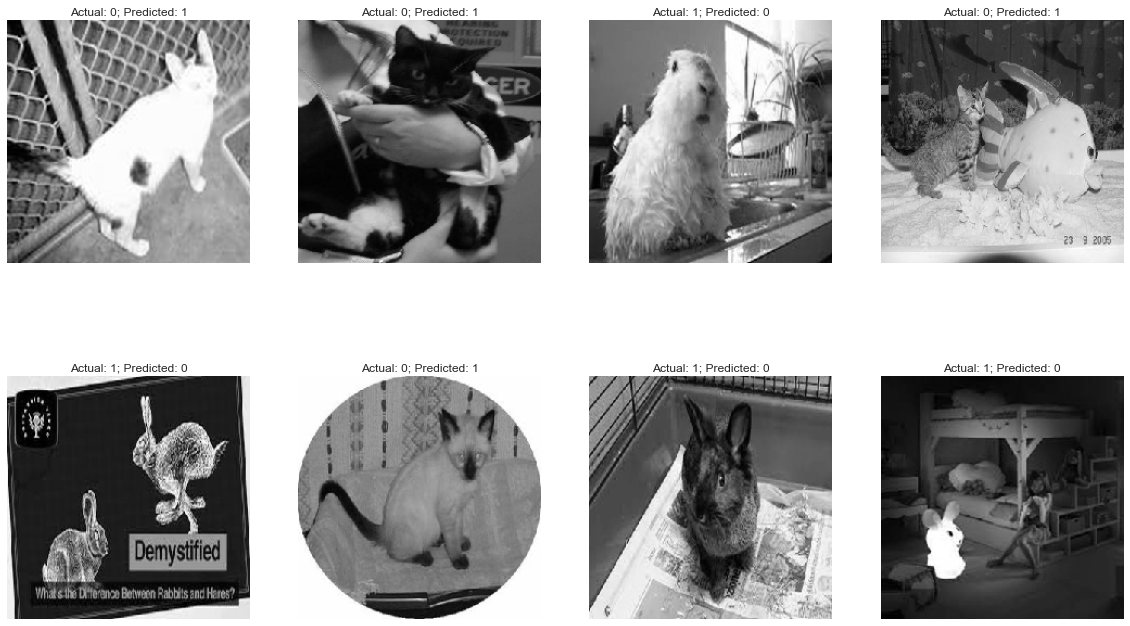

In [246]:
plt.figure(figsize = (20 , 12))

j = 1
for i in np.where(y_test_reshape != encoder_pred)[0]:

    plt.subplot(2,4,j)
    plt.imshow(X_test[i].reshape(224,224), cmap = 'gray')
    plt.title(f'Actual: {y_test_reshape[i]}; Predicted: {encoder_pred[i]}')
    plt.axis("off")
    j += 1

## Basic Encoder

In [213]:
input_img = Input(shape = (img_height, img_width, 1))
layer = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
layer = Conv2D(16, (6, 6), activation='relu', padding='same')(layer)
pool = MaxPooling2D((7, 7), padding='same')(layer)
layer = Conv2D(32, (3, 3), activation='relu', padding='same')(pool)
layer = Conv2D(32, (6, 6), activation='relu', padding='same')(layer)
pool = MaxPooling2D((4, 4), padding='same')(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
layer = Conv2D(64, (6, 6), activation='relu', padding='same')(layer)
pool = MaxPooling2D((4, 4), padding='same')(layer)
flatten = Flatten()(pool)
encoded = Dense(128, activation='relu')(flatten)

inv_layer = Dense(256, activation='relu')(encoded)
inv_layer = Reshape((2, 2, 64))(inv_layer)
inv_layer = UpSampling2D((4, 4))(inv_layer)
inv_layer = Conv2D(64, (6, 6), activation='relu', padding='same')(inv_layer)
inv_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(inv_layer)
inv_layer = UpSampling2D((4, 4))(inv_layer)
inv_layer = Conv2D(32, (6, 6), activation='relu', padding='same')(inv_layer)
inv_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(inv_layer)
inv_layer = UpSampling2D((7, 7))(inv_layer)
inv_layer = Conv2D(16, (6, 6), activation='relu', padding='same')(inv_layer)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(inv_layer)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), 
                loss='mean_squared_error')

In [214]:
autoencoder.summary()

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_848 (Conv2D)          (None, 224, 224, 16)      160       
_________________________________________________________________
conv2d_849 (Conv2D)          (None, 224, 224, 16)      9232      
_________________________________________________________________
max_pooling2d_230 (MaxPoolin (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_850 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_851 (Conv2D)          (None, 32, 32, 32)        36896     
_________________________________________________________________
max_pooling2d_231 (MaxPoolin (None, 8, 8, 32)          0  

In [215]:
model_name = "auto_encoder.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [216]:
try:
    autoencoder.fit(X_train, X_train, epochs=25, validation_data=(X_test, X_test), callbacks=[checkpoint, earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/25
50/50 [==============================] - 244s 5s/step - loss: 11495.4378 - val_loss: 3347.5740

Epoch 00001: val_loss improved from inf to 3347.57397, saving model to auto_encoder.h5
Epoch 2/25
50/50 [==============================] - 229s 5s/step - loss: 3078.3836 - val_loss: 2226.6443

Epoch 00002: val_loss improved from 3347.57397 to 2226.64429, saving model to auto_encoder.h5
Epoch 3/25
50/50 [==============================] - 229s 5s/step - loss: 2143.9342 - val_loss: 1934.4160

Epoch 00003: val_loss improved from 2226.64429 to 1934.41602, saving model to auto_encoder.h5
Epoch 4/25
50/50 [==============================] - 233s 5s/step - loss: 1948.0468 - val_loss: 1840.8123

Epoch 00004: val_loss improved from 1934.41602 to 1840.81226, saving model to auto_encoder.h5
Epoch 5/25
50/50 [==============================] - 234s 5s/step - loss: 1917.2051 - val_loss: 1735.4052

Epoch 00005: val_loss improved from 1840.81226 to 1735.40515, saving model to auto_encoder.h5
Epoch 

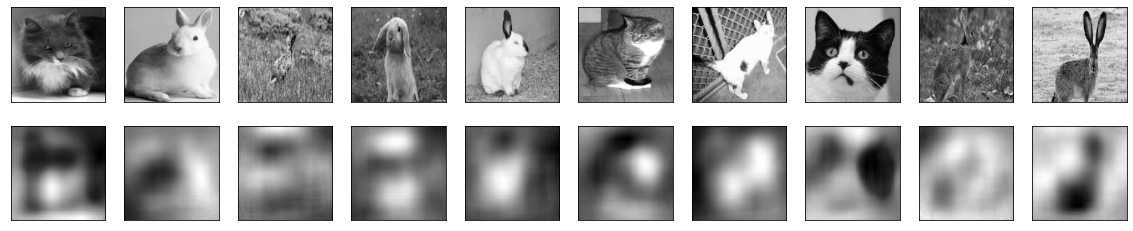

In [219]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
# autoencoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_119').output)
autoencoder_model = load_model('models/auto_encoder.h5')
autoencoder_X_train = autoencoder_model.predict(X_train)
autoencoder_X_test = autoencoder_model.predict(X_test)

In [235]:
autoencoder_logreg = LogisticRegression(random_state = 0, max_iter = 200, solver = 'saga')
autoencoder_logreg.fit(autoencoder_X_train, y_train_reshape)

c:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(max_iter=200, random_state=0, solver='saga')

In [236]:
autoencoder_pred = autoencoder_logreg.predict(autoencoder_X_test)
print(classification_report(y_test_reshape, autoencoder_pred, target_names = ['cat', 'rabbit']))

              precision    recall  f1-score   support

         cat       0.71      0.67      0.69       207
      rabbit       0.69      0.73      0.71       207

    accuracy                           0.70       414
   macro avg       0.70      0.70      0.70       414
weighted avg       0.70      0.70      0.70       414



In [238]:
confusion_matrix(y_test_reshape, autoencoder_pred)

array([[138,  69],
       [ 56, 151]], dtype=int64)

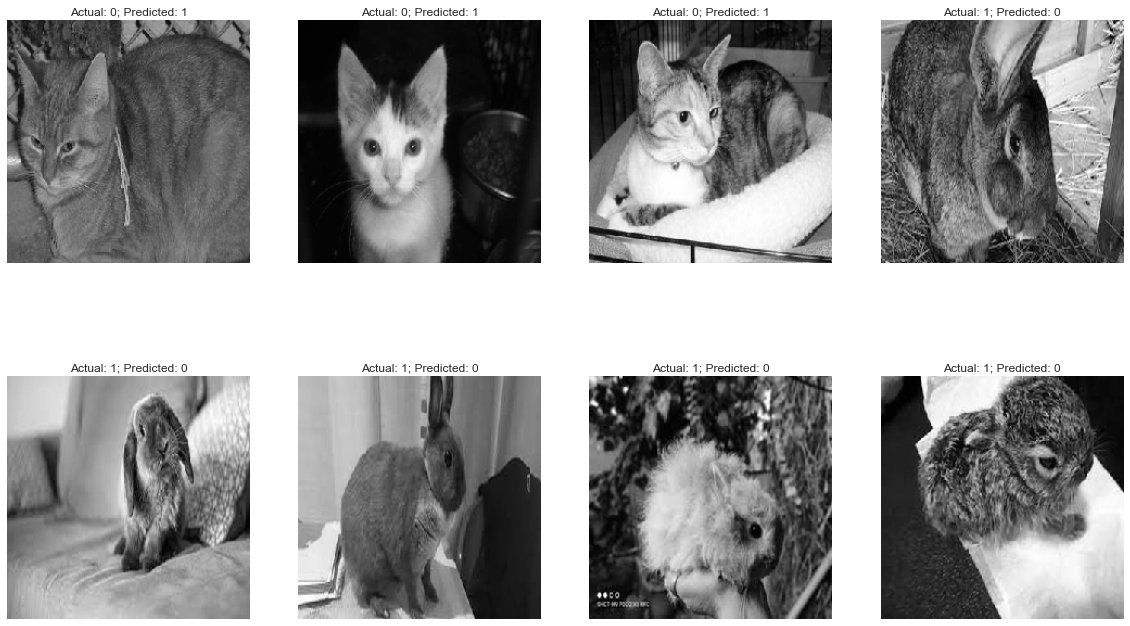

In [264]:
np.random.seed(3)
wrongs = np.where(y_test_reshape != autoencoder_pred)[0]
np.random.shuffle(wrongs)
plt.figure(figsize = (20 , 12))

j = 1
for i in wrongs[:8]:

    plt.subplot(2,4,j)
    plt.imshow(X_test[i].reshape(224,224), cmap = 'gray')
    plt.title(f'Actual: {y_test_reshape[i]}; Predicted: {autoencoder_pred[i]}')
    plt.axis("off")
    j += 1

In [259]:
wrongs[0:7]

array([ 30, 178, 154,  99, 222, 338, 196], dtype=int64)

In [267]:
%pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [11]:
def visual_cnn(path, model_name):
    visualkeras.layered_view(model_name, to_file=f'images/layer_{path}.png').show()
    visualkeras.graph_view(model_name, to_file=f'images/graph_{path}.png').show()

In [12]:
visual_cnn('autoencoder', autoencoder_model)

In [15]:
visual_cnn('vgg199', vgg19_custom)